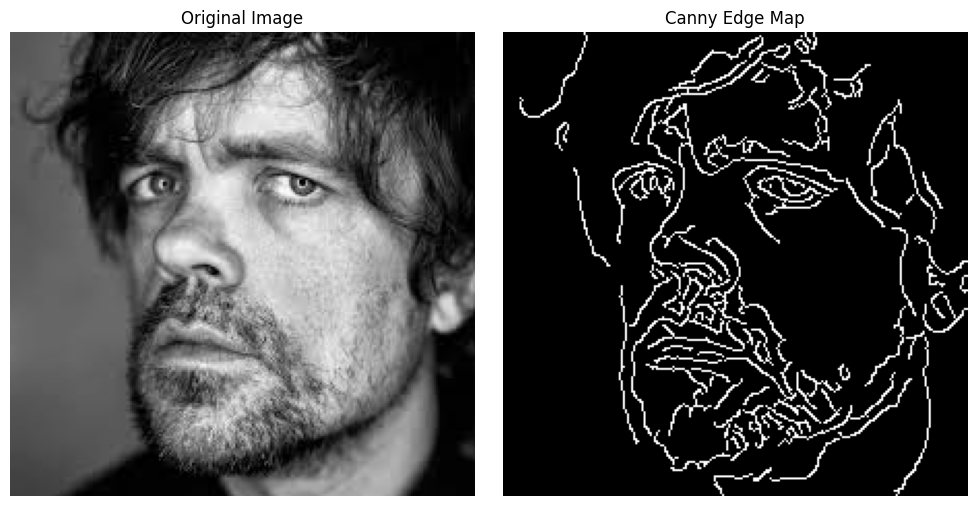

In [12]:
import cv2
import matplotlib.pyplot as plt

# Load grayscale image
image = cv2.imread("forgradient.jpeg", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(image, (5, 5), 1.4)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Canny Edge Map")
plt.imshow(edges, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
edges.shape

(225, 225)

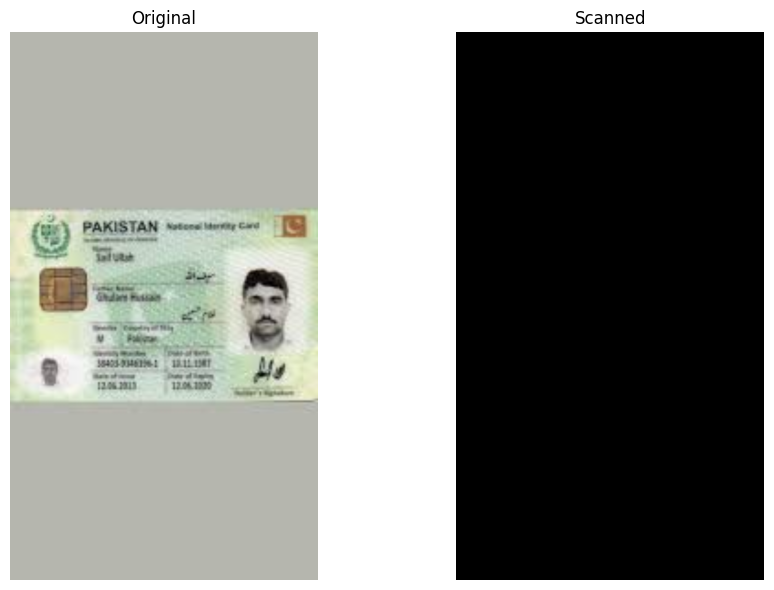

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # Order points as: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]       # top-left
    rect[2] = pts[np.argmax(s)]       # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]    # top-right
    rect[3] = pts[np.argmax(diff)]    # bottom-left

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute width and height of new image
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Destination points
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Perspective transform
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def scan_document(image_path):
    # Load and resize image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (800, int(image.shape[0] * 800 / image.shape[1])))
    orig = image.copy()

    # Preprocess
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)

    # Find contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Find the document contour
    doc_cnt = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            doc_cnt = approx
            break

    if doc_cnt is None:
        raise ValueError("Document boundary not found.")

    # Apply perspective transform
    warped = four_point_transform(orig, doc_cnt.reshape(4, 2))

    # Convert to grayscale and apply adaptive threshold
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    scanned = cv2.adaptiveThreshold(warped_gray, 255,
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

    return scanned

In [29]:
img = cv2.imread("document.png")

# Get brightened color scan
scanned = scan_document(img, mode="color", filter="contrast")

# Get gray scan with contrast enhancement
# scanned = scan_document(img, mode="gray", filter="contrast")

cv2.imshow("Scanned", scanned)
cv2.waitKey(0)
cv2.destroyAllWindows()
